# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = 'rainfall'
    n_folds = 10
    seed = 2100
    time_limit = 3600 * 11

    pipeline = 3

# Loading data and predefining folds

In [3]:
def get_data(pipeline):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")

    test.winddirection = test.winddirection.fillna(test.winddirection.median())
    
    if pipeline == 1:
        return train, test, None
    
    original = pd.read_csv(CFG.original_path, encoding="gbk")
    original["date"] = pd.to_datetime(original[["year", "month", "day"]])
    original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
    original["day"] = original.date.dt.dayofyear
    original = original.drop("date", axis=1)
    original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
    original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
    original.sunshine = original.sunshine.replace('-', 0).astype(float)
    original.windspeed = original.windspeed.fillna(original.windspeed.mean())
    for col in original.columns:
        original[col] = original[col].astype(train[col].dtype)
        
    if pipeline == 2:
        return train, test, original
        
    original_2 = pd.read_csv(CFG.original_path_2)
    original_2.columns = original_2.columns.str.replace(" ", "")
    original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
    original_2.winddirection = original_2.winddirection.fillna(original_2.winddirection.mean())
    original_2.windspeed = original_2.windspeed.fillna(original_2.windspeed.mean())
    original_2.day = original_2.index + 1
    for col in original_2.columns:
        original_2[col] = original_2[col].astype(train[col].dtype)
        
    if pipeline == 3:
        return train, test, original_2
        
    original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
    original_combined = original_combined.drop_duplicates().reset_index(drop=True)

    return train, test, original_combined

In [4]:
train, test, original = get_data(CFG.pipeline)

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [7]:
if original is None:
    predictor.fit(
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )
else:
    predictor.fit_pseudolabel(
        pseudo_data=original,
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.18 GB / 31.35 GB (96.3%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the

(autoscaler +1m36s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8955	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.76s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTreesGini_BAG_L1 ... Training model for up to 6490.99s of the 9791.11s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.886	 = Validation score   (roc_auc)
(_dystack pid=178) 	10.82s	 = Training   runtime
(_dystack pid=178) 	0.93s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTreesEntr_BAG_L1 ... Training model for up to 6477.25s of the 9777.38s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers

(autoscaler +2m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8881	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.63s	 = Training   runtime
(_dystack pid=178) 	1.03s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 6462.56s of the 9762.69s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=4305) No improvement since epoch 9: early stopping
(_dystack pid=178) 	0.8882	 = Validation score   (roc_auc)
(_dystack pid=178) 	29.77s	 = Training   runtime
(_dystack pid=178) 	0.14s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_BAG_L1 ... Training model for up to 6429.89s of the 9730.01s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=178) 	8.8s	 = Training   runtime
(_dystack pid=178) 	0.07s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 6418.03s of the 9718.16s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +3m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=178) 	39.05s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 6376.03s of the 9676.15s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=178) 	0.8664	 = Validation score   (roc_auc)
(_dystack pid=178) 	16.52s	 = Training   runtime
(_dystack pid=178) 	0.03s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 6356.57s of the 9656.69s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +4m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8975	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.79s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r79_BAG_L1 ... Training model for up to 6340.81s of the 9640.93s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +4m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.41s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r131_BAG_L1 ... Training model for up to 6301.61s of the 9601.73s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=178) 	0.8869	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.38s	 = Training   runtime
(_dystack pid=178) 	0.06s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 6284.21s of the 9584.33s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +5m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=6522) No improvement since epoch 9: early stopping
(_ray_fit pid=6772) No improvement since epoch 4: early stopping [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=6893) No improvement since epoch 14: early stopping [repeated 4x across cluster]
(_dystack pid=178) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.13s	 = Training   runtime
(_dystack pid=178) 	0.18s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 6245.10s of the 9545.23s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +5m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.68s	 = Training   runtime
(_dystack pid=178) 	0.03s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r96_BAG_L1 ... Training model for up to 6205.23s of the 9505.35s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=6895) No improvement since epoch 15: early stopping


(autoscaler +6m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=7379) [1000]	valid_set's binary_logloss: 0.303317
(_ray_fit pid=7508) [1000]	valid_set's binary_logloss: 0.346226 [repeated 8x across cluster]


(_dystack pid=178) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.2s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 6188.14s of the 9488.26s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +7m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=178) 	33.83s	 = Training   runtime
(_dystack pid=178) 	0.13s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 6151.44s of the 9451.56s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.12%)
(_dystack pid=178) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.32s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r42_BAG_L1 ... Training model for up to 6136.15s of the 9436.27s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +7m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8856	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.38s	 = Training   runtime
(_dystack pid=178) 	0.81s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 6121.79s of the 9421.92s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8974	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.78s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r102_BAG_L1 ... Training model for up to 6106.15s of the 9406.27s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +8m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9269) No improvement since epoch 2: early stopping


(autoscaler +8m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9636) No improvement since epoch 2: early stopping
(_dystack pid=178) 	0.8982	 = Validation score   (roc_auc)
(_dystack pid=178) 	65.03s	 = Training   runtime
(_dystack pid=178) 	0.36s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r13_BAG_L1 ... Training model for up to 6038.24s of the 9338.37s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +9m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=178) 	28.56s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r195_BAG_L1 ... Training model for up to 6006.79s of the 9306.91s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +10m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8804	 = Validation score   (roc_auc)
(_dystack pid=178) 	18.59s	 = Training   runtime
(_dystack pid=178) 	0.93s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r188_BAG_L1 ... Training model for up to 5985.31s of the 9285.44s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=178) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.94s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 5968.51s of the 9268.63s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +10m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=10917) No improvement since epoch 9: early stopping
(_ray_fit pid=11102) No improvement since epoch 7: early stopping
(_ray_fit pid=11106) No improvement since epoch 9: early stopping
(_ray_fit pid=11289) No improvement since epoch 10: early stopping
(_dystack pid=178) 	0.8918	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.48s	 = Training   runtime
(_dystack pid=178) 	0.2s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r89_BAG_L1 ... Training model for up to 5928.94s of the 9229.07s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +11m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=178) 	8.56s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r30_BAG_L1 ... Training model for up to 5917.44s of the 9217.56s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +11m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=178) 	56.99s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r130_BAG_L1 ... Training model for up to 5857.44s of the 9157.56s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +12m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8945	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.98s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r86_BAG_L1 ... Training model for up to 5841.56s of the 9141.69s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +13m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=178) 	30.98s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r50_BAG_L1 ... Training model for up to 5807.62s of the 9107.74s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.07s	 = Training   runtime
(_dystack pid=178) 	0.03s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r11_BAG_L1 ... Training model for up to 5791.73s of the 9091.85s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +13m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=13174) No improvement since epoch 6: early stopping
(_ray_fit pid=13420) No improvement since epoch 9: early stopping [repeated 3x across cluster]
(_ray_fit pid=13546) No improvement since epoch 10: early stopping
(_dystack pid=178) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=178) 	43.33s	 = Training   runtime
(_dystack pid=178) 	0.23s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r194_BAG_L1 ... Training model for up to 5745.63s of the 9045.75s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +14m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8865	 = Validation score   (roc_auc)
(_dystack pid=178) 	8.61s	 = Training   runtime
(_dystack pid=178) 	0.08s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r172_BAG_L1 ... Training model for up to 5733.86s of the 9033.99s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=178) 	10.61s	 = Training   runtime
(_dystack pid=178) 	0.83s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r69_BAG_L1 ... Training model for up to 5720.29s of the 9020.41s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8987	 = Validation scor

(autoscaler +14m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=14821) No improvement since epoch 16: early stopping
(_ray_fit pid=15002) No improvement since epoch 17: early stopping [repeated 2x across cluster]
(_ray_fit pid=15192) No improvement since epoch 20: early stopping [repeated 4x across cluster]
(_dystack pid=178) 	0.8954	 = Validation score   (roc_auc)
(_dystack pid=178) 	30.83s	 = Training   runtime
(_dystack pid=178) 	0.16s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r14_BAG_L1 ... Training model for up to 5671.08s of the 8971.20s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +15m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8975	 = Validation score   (roc_auc)
(_dystack pid=178) 	27.48s	 = Training   runtime
(_dystack pid=178) 	0.09s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r161_BAG_L1 ... Training model for up to 5640.45s of the 8940.57s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +16m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8902	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.27s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r143_BAG_L1 ... Training model for up to 5620.10s of the 8920.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8924	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.06s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r70_BAG_L1 ... Training model for up to 5593.88s of the 8894.01s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +16m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.3s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r156_BAG_L1 ... Training model for up to 5569.47s of the 8869.59s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +17m23s) Warning: The following resource request cannot be sch


(_ray_fit pid=16851) No improvement since epoch 3: early stopping
(_ray_fit pid=16849) No improvement since epoch 16: early stopping
(_ray_fit pid=16850) No improvement since epoch 23: early stopping
(_ray_fit pid=17033) No improvement since epoch 3: early stopping


(autoscaler +17m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=17067) No improvement since epoch 3: early stopping
(_ray_fit pid=17113) No improvement since epoch 8: early stopping [repeated 2x across cluster]
(_ray_fit pid=17221) No improvement since epoch 4: early stopping
(_dystack pid=178) 	0.8932	 = Validation score   (roc_auc)
(_dystack pid=178) 	68.99s	 = Training   runtime
(_dystack pid=178) 	0.28s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r196_BAG_L1 ... Training model for up to 5497.64s of the 8797.77s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(_ray_fit pid=17317) [1000]	valid_set's binary_logloss: 0.35315 [repeated 3x across cluster]
(autoscaler +18m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=17448) [1000]	valid_set's binary_logloss: 0.349358 [repeated 7x across cluster]
(_ray_fit pid=17582) [1000]	valid_set's binary_logloss: 0.321727 [repeated 3x across cluster]


(_dystack pid=178) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.23s	 = Training   runtime
(_dystack pid=178) 	0.54s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 5475.08s of the 8775.21s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.8823	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.33s	 = Training   runtime
(_dystack pid=178) 	0.93s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 5454.78s of the 8754.90s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +19m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8944	 = Validation score   (roc_auc)
(_dystack pid=178) 	15.19s	 = Training   runtime
(_dystack pid=178) 	0.01s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 5436.65s of the 8736.77s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +19m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=18696) No improvement since epoch 8: early stopping
(_ray_fit pid=18878) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=178) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.98s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r41_BAG_L1 ... Training model for up to 5396.80s of the 8696.93s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +20m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8947	 = Validation score   (roc_auc)
(_dystack pid=178) 	38.89s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r98_BAG_L1 ... Training model for up to 5354.78s of the 8654.90s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +20m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8912	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.67s	 = Training   runtime
(_dystack pid=178) 	0.14s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r15_BAG_L1 ... Training model for up to 5339.25s of the 8639.37s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8932	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.2s	 = Training   runtime
(_dystack pid=178) 	0.07s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r158_BAG_L1 ... Training model for up to 5323.10s of the 8623.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +21m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.885	 = Validation score   (roc_auc)
(_dystack pid=178) 	38.91s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r86_BAG_L1 ... Training model for up to 5281.32s of the 8581.44s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +22m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8936	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.41s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r37_BAG_L1 ... Training model for up to 5256.98s of the 8557.10s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +22m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=21132) No improvement since epoch 20: early stopping
(_dystack pid=178) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=178) 	28.13s	 = Training   runtime
(_dystack pid=178) 	0.17s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r197_BAG_L1 ... Training model for up to 5226.03s of the 8526.15s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +23m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=178) 	24.99s	 = Training   runtime
(_dystack pid=178) 	0.09s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r49_BAG_L1 ... Training model for up to 5197.89s of the 8498.01s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8963	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.25s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r49_BAG_L1 ... Training model for up to 5182.30s of the 8482.43s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +23m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.886	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.48s	 = Training   runtime
(_dystack pid=178) 	0.83s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r143_BAG_L1 ... Training model for up to 5166.88s of the 8467.00s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=178) 	0.8851	 = Validation score   (roc_auc)
(_dystack pid=178) 	15.29s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r127_BAG_L1 ... Training model for up to 5148.48s of the 8448.60s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +24m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8878	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.41s	 = Training   runtime
(_dystack pid=178) 	1.13s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r134_BAG_L1 ... Training model for up to 5126.04s of the 8426.16s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +24m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23250) No improvement since epoch 16: early stopping
(_ray_fit pid=23253) No improvement since epoch 23: early stopping [repeated 2x across cluster]


(autoscaler +25m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23499) No improvement since epoch 13: early stopping
(_ray_fit pid=23434) No improvement since epoch 25: early stopping
(_ray_fit pid=23532) No improvement since epoch 22: early stopping
(_ray_fit pid=23653) No improvement since epoch 25: early stopping
(_dystack pid=178) 	0.8951	 = Validation score   (roc_auc)
(_dystack pid=178) 	115.63s	 = Training   runtime
(_dystack pid=178) 	0.33s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r34_BAG_L1 ... Training model for up to 5007.52s of the 8307.64s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +26m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8925	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.37s	 = Training   runtime
(_dystack pid=178) 	0.82s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r94_BAG_L1 ... Training model for up to 4992.16s of the 8292.29s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(_ray_fit pid=24184) [1000]	valid_set's binary_logloss: 0.294527 [repeated 5x across cluster]


(_dystack pid=178) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.21s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r143_BAG_L1 ... Training model for up to 4977.10s of the 8277.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +27m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=178) 	42.19s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r128_BAG_L1 ... Training model for up to 4931.92s of the 8232.04s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +27m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8928	 = Validation score   (roc_auc)
(_dystack pid=178) 	32.3s	 = Training   runtime
(_dystack pid=178) 	0.03s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r111_BAG_L1 ... Training model for up to 4896.76s of the 8196.88s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +28m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +29m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=178) 	53.87s	 = Training   runtime
(_dystack pid=178) 	0.43s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r31_BAG_L1 ... Training model for up to 4840.03s of the 8140.16s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +29m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=178) 	29.12s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r4_BAG_L1 ... Training model for up to 4807.70s of the 8107.83s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.8926	 = Validation score   (roc_auc)
(_dystack pid=178) 	10.99s	 = Training   runtime
(_dystack pid=178) 	0.78s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r65_BAG_L1 ... Training model for up to 4793.30s of the 8093.42s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +30m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8895	 = Validation score   (roc_auc)
(_dystack pid=178) 	22.98s	 = Training   runtime
(_dystack pid=178) 	0.13s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r88_BAG_L1 ... Training model for up to 4767.47s of the 8067.60s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=27043) No improvement since epoch 7: early stopping


(autoscaler +30m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=27232) No improvement since epoch 5: early stopping [repeated 4x across cluster]
(_dystack pid=178) 	0.8739	 = Validation score   (roc_auc)
(_dystack pid=178) 	22.63s	 = Training   runtime
(_dystack pid=178) 	0.13s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r30_BAG_L1 ... Training model for up to 4741.84s of the 8041.97s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_ray_fit pid=27226) No improvement since epoch 5: early stopping [repeated 3x across cluster]


(_ray_fit pid=27510) [1000]	valid_set's binary_logloss: 0.296375
(_ray_fit pid=27508) [1000]	valid_set's binary_logloss: 0.304081
(_ray_fit pid=27778) [1000]	valid_set's binary_logloss: 0.317417


(_dystack pid=178) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.65s	 = Training   runtime
(_dystack pid=178) 	0.27s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r49_BAG_L1 ... Training model for up to 4724.09s of the 8024.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +31m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.22s	 = Training   runtime
(_dystack pid=178) 	0.08s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r5_BAG_L1 ... Training model for up to 4712.09s of the 8012.21s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.66s	 = Training   runtime
(_dystack pid=178) 	0.01s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r87_BAG_L1 ... Training model for up to 4697.61s of the 7997.73s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +31m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=178) 	38.69s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r71_BAG_L1 ... Training model for up to 4656.09s of the 7956.21s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +32m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=178) 	22.33s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r143_BAG_L1 ... Training model for up to 4630.84s of the 7930.96s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=178) 	0.8955	 = Validation score   (roc_auc)
(_dystack pid=178) 	15.02s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r178_BAG_L1 ... Training model for up to 4612.37s of the 7912.49s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +33m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8912	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.62s	 = Training   runtime
(_dystack pid=178) 	0.79s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r166_BAG_L1 ... Training model for up to 4596.88s of the 7897.01s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.8824	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.31s	 = Training   runtime
(_dystack pid=178) 	1.02s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r31_BAG_L1 ... Training model for up to 4576.22s of the 7876.34s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +33m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.64s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r185_BAG_L1 ... Training model for up to 4563.81s of the 7863.93s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.8924	 = Validation score   (roc_auc)
(_dystack pid=178) 	32.18s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r160_BAG_L1 ... Training model for up to 4528.36s of the 7828.49s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +34m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=178) 	29.88s	 = Training   runtime
(_dystack pid=178) 	0.19s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r60_BAG_L1 ... Training model for up to 4495.45s of the 7795.58s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +35m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8984	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.86s	 = Training   runtime
(_dystack pid=178) 	0.03s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r15_BAG_L1 ... Training model for up to 4479.30s of the 7779.42s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.8847	 = Validation score   (roc_auc)
(_dystack pid=178) 	18.01s	 = Training   runtime
(_dystack pid=178) 	0.92s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r135_BAG_L1 ... Training model for up to 4458.46s of the 7758.58s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)


(autoscaler +35m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.67s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r22_BAG_L1 ... Training model for up to 4442.96s of the 7743.09s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=178) 	0.8915	 = Validation score   (roc_auc)
(_dystack pid=178) 	8.77s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r69_BAG_L1 ... Training model for up to 4431.32s of the 7731.44s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +36m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=178) 	29.19s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r6_BAG_L1 ... Training model for up to 4399.37s of the 7699.49s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.0s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r138_BAG_L1 ... Training model for up to 4384.22s of the 7684.34s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +37m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34144) No improvement since epoch 16: early stopping
(_ray_fit pid=34329) No improvement since epoch 17: early stopping [repeated 3x across cluster]


(autoscaler +37m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34547) No improvement since epoch 15: early stopping [repeated 4x across cluster]
(_dystack pid=178) 	0.8916	 = Validation score   (roc_auc)
(_dystack pid=178) 	49.92s	 = Training   runtime
(_dystack pid=178) 	0.2s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r121_BAG_L1 ... Training model for up to 4331.46s of the 7631.58s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)
(_dystack pid=178) 	0.8893	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.51s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r172_BAG_L1 ... Training model for up to 4311.13s of the 7611.25s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +38m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34945) No improvement since epoch 10: early stopping
(_ray_fit pid=35130) No improvement since epoch 4: early stopping [repeated 3x across cluster]
(_ray_fit pid=35311) No improvement since epoch 11: early stopping
(_dystack pid=178) 	0.8917	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.66s	 = Training   runtime
(_dystack pid=178) 	0.14s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r180_BAG_L1 ... Training model for up to 4284.47s of the 7584.59s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +38m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8966	 = Validation score   (roc_auc)
(_dystack pid=178) 	25.48s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r76_BAG_L1 ... Training model for up to 4256.09s of the 7556.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +39m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=178) 	24.46s	 = Training   runtime
(_dystack pid=178) 	0.09s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r197_BAG_L1 ... Training model for up to 4228.78s of the 7528.90s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=178) 	0.8856	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.82s	 = Training   runtime
(_dystack pid=178) 	0.87s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r121_BAG_L1 ... Training model for up to 4210.77s of the 7510.90s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +39m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.888	 = Validation score   (roc_auc)
(_dystack pid=178) 	40.49s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r127_BAG_L1 ... Training model for up to 4167.30s of the 7467.42s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +40m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.42s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r16_BAG_L1 ... Training model for up to 4143.02s of the 7443.14s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +41m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8789	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.28s	 = Training   runtime
(_dystack pid=178) 	1.06s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r194_BAG_L1 ... Training model for up to 4116.37s of the 7416.50s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +41m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=178) 	25.94s	 = Training   runtime
(_dystack pid=178) 	0.17s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r12_BAG_L1 ... Training model for up to 4087.68s of the 7387.81s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=178) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.52s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r135_BAG_L1 ... Training model for up to 4067.08s of the 7367.21s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +42m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8954	 = Validation score   (roc_auc)
(_dystack pid=178) 	41.16s	 = Training   runtime
(_dystack pid=178) 	0.13s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r4_BAG_L1 ... Training model for up to 4023.07s of the 7323.19s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +43m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=39346) No improvement since epoch 18: early stopping
(_ray_fit pid=39529) No improvement since epoch 11: early stopping [repeated 2x across cluster]
(_dystack pid=178) 	0.8959	 = Validation score   (roc_auc)
(_dystack pid=178) 	26.4s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r126_BAG_L1 ... Training model for up to 3993.71s of the 7293.83s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +43m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8901	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.95s	 = Training   runtime
(_dystack pid=178) 	0.83s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r36_BAG_L1 ... Training model for up to 3977.53s of the 7277.66s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +44m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8956	 = Validation score   (roc_auc)
(_dystack pid=178) 	35.54s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r100_BAG_L1 ... Training model for up to 3939.18s of the 7239.30s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +44m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=40452) No improvement since epoch 9: early stopping


(autoscaler +45m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=40697) No improvement since epoch 7: early stopping [repeated 3x across cluster]
(_dystack pid=178) 	0.8855	 = Validation score   (roc_auc)
(_dystack pid=178) 	95.6s	 = Training   runtime
(_dystack pid=178) 	0.35s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r163_BAG_L1 ... Training model for up to 3840.57s of the 7140.69s of remaining time.
(_ray_fit pid=40731) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +46m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.52s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r198_BAG_L1 ... Training model for up to 3826.22s of the 7126.34s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=178) 	0.8966	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.18s	 = Training   runtime
(_dystack pid=178) 	0.02s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r187_BAG_L1 ... Training model for up to 3809.31s of the 7109.43s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +46m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.89	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.82s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r19_BAG_L1 ... Training model for up to 3782.40s of the 7082.52s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +47m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8941	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.77s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r95_BAG_L1 ... Training model for up to 3755.46s of the 7055.59s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=178) 	0.892	 = Validation score   (roc_auc)
(_dystack pid=178) 	8.31s	 = Training   runtime
(_dystack pid=178) 	0.06s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r34_BAG_L1 ... Training model for up to 3743.66s of the 7043.78s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.11%)
(_dystack pid=178) 	0.8907	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.49s	 = Training   runtime
(_dystack pid=178) 	0.0

(autoscaler +47m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8972	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.82s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r1_BAG_L1 ... Training model for up to 3715.70s of the 7015.82s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +48m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8903	 = Validation score   (roc_auc)
(_dystack pid=178) 	34.38s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r89_BAG_L1 ... Training model for up to 3678.38s of the 6978.50s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +49m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8935	 = Validation score   (roc_auc)
(_dystack pid=178) 	38.07s	 = Training   runtime
(_dystack pid=178) 	0.14s	 = Validation runtime
(_dystack pid=178) Fitting model: WeightedEnsemble_L2 ... Training model for up to 659.53s of the 6937.47s of remaining time.
(_dystack pid=178) 	Ensemble Weights: {'CatBoost_r50_BAG_L1': 0.4, 'NeuralNetFastAI_r11_BAG_L1': 0.28, 'NeuralNetTorch_r197_BAG_L1': 0.12, 'KNeighborsDist_BAG_L1': 0.04, 'NeuralNetFastAI_r102_BAG_L1': 0.04, 'XGBoost_r89_BAG_L1': 0.04, 'CatBoost_r69_BAG_L1': 0.04, 'NeuralNetTorch_r14_BAG_L1': 0.04}
(_dystack pid=178) 	0.9061	 = Validation score   (roc_auc)
(_dystack pid=178) 	0.18s	 = Training   runtime
(_dystack pid=178) 	0.0s	 = Validation runtime
(_dystack pid=178) Fitting 108 L2 models, fit_strategy="sequential" ...
(_dystack pid=178) Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 6937.27s of the 6937.04s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting

(autoscaler +49m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8992	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.31s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 6903.73s of the 6903.49s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8974	 = Validation score   (roc_auc)
(_dystack pid=178) 	15.15s	 = Training   runtime
(_dystack pid=178) 	1.03s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 6885.61s of the 6885.37s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 wo

(autoscaler +50m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9009	 = Validation score   (roc_auc)
(_dystack pid=178) 	15.33s	 = Training   runtime
(_dystack pid=178) 	0.93s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_BAG_L2 ... Training model for up to 6867.28s of the 6867.05s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)
(_dystack pid=178) 	0.9051	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.91s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTreesGini_BAG_L2 ... Training model for up to 6844.51s of the 6844.27s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +50m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=178) 	10.81s	 = Training   runtime
(_dystack pid=178) 	0.82s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTreesEntr_BAG_L2 ... Training model for up to 6830.80s of the 6830.56s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.9028	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.04s	 = Training   runtime
(_dystack pid=178) 	0.9s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 6816.61s of the 6816.37s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +51m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=47170) No improvement since epoch 9: early stopping
(_ray_fit pid=47358) No improvement since epoch 7: early stopping
(_ray_fit pid=47356) No improvement since epoch 8: early stopping
(_dystack pid=178) 	0.8965	 = Validation score   (roc_auc)
(_dystack pid=178) 	25.8s	 = Training   runtime
(_dystack pid=178) 	0.14s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_BAG_L2 ... Training model for up to 6787.90s of the 6787.67s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=178) 	0.9002	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.96s	 = Training   runtime
(_dystack pid=178) 	0.08s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 6774.76s of the 6774.52s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocal

(autoscaler +52m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=178) 	34.39s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 6737.47s of the 6737.24s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +52m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8803	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.03s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r177_BAG_L2 ... Training model for up to 6713.44s of the 6713.20s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +53m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9034	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.25s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r79_BAG_L2 ... Training model for up to 6691.24s of the 6691.00s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +53m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=178) 	44.47s	 = Training   runtime
(_dystack pid=178) 	0.24s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r131_BAG_L2 ... Training model for up to 6643.84s of the 6643.60s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.15%)
(_dystack pid=178) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.0s	 = Training   runtime
(_dystack pid=178) 	0.09s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r191_BAG_L2 ... Training model for up to 6623.87s of the 6623.63s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +54m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=49752) No improvement since epoch 14: early stopping
(_ray_fit pid=49973) No improvement since epoch 4: early stopping
(_ray_fit pid=49968) No improvement since epoch 13: early stopping
(_ray_fit pid=50123) No improvement since epoch 16: early stopping
(_ray_fit pid=50155) No improvement since epoch 22: early stopping
(_dystack pid=178) 	0.8963	 = Validation score   (roc_auc)
(_dystack pid=178) 	37.86s	 = Training   runtime
(_dystack pid=178) 	0.17s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r9_BAG_L2 ... Training model for up to 6583.11s of the 6582.87s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +55m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +55m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=178) 	76.97s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r96_BAG_L2 ... Training model for up to 6503.25s of the 6503.01s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +56m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=50612) [1000]	valid_set's binary_logloss: 0.272771
(_ray_fit pid=50612) [2000]	valid_set's binary_logloss: 0.272125
(_ray_fit pid=50612) [3000]	valid_set's binary_logloss: 0.270808
(_ray_fit pid=50612) [4000]	valid_set's binary_logloss: 0.270575
(_ray_fit pid=50737) [1000]	valid_set's binary_logloss: 0.336464


(_dystack pid=178) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.0s	 = Training   runtime
(_dystack pid=178) 	0.17s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 6486.23s of the 6485.99s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +57m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=178) 	42.21s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 6441.20s of the 6440.96s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.24%)


(autoscaler +57m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9021	 = Validation score   (roc_auc)
(_dystack pid=178) 	16.73s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r42_BAG_L2 ... Training model for up to 6421.37s of the 6421.14s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.899	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.66s	 = Training   runtime
(_dystack pid=178) 	0.81s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r137_BAG_L2 ... Training model for up to 6405.81s of the 6405.57s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=178) 	0.9039	 = Validation scor

(autoscaler +58m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +59m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=178) 	64.99s	 = Training   runtime
(_dystack pid=178) 	0.3s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r13_BAG_L2 ... Training model for up to 6320.83s of the 6320.59s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +59m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9037	 = Validation score   (roc_auc)
(_dystack pid=178) 	57.91s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r195_BAG_L2 ... Training model for up to 6259.89s of the 6259.65s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.896	 = Validation score   (roc_auc)
(_dystack pid=178) 	32.85s	 = Training   runtime
(_dystack pid=178) 	1.19s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r188_BAG_L2 ... Training model for up to 6224.04s of the 6223.80s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h1m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.79s	 = Training   runtime
(_dystack pid=178) 	0.08s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r145_BAG_L2 ... Training model for up to 6206.38s of the 6206.14s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=54156) No improvement since epoch 9: early stopping
(_ray_fit pid=54343) No improvement since epoch 9: early stopping


(autoscaler +1h2m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=54527) No improvement since epoch 10: early stopping
(_dystack pid=178) 	0.9022	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.34s	 = Training   runtime
(_dystack pid=178) 	0.21s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r89_BAG_L2 ... Training model for up to 6167.08s of the 6166.84s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=178) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.28s	 = Training   runtime
(_dystack pid=178) 	0.07s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r30_BAG_L2 ... Training model for up to 6154.58s of the 6154.35s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_ray_fit pid=54558) No improvement since epoch 10: earl

(autoscaler +1h2m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.898	 = Validation score   (roc_auc)
(_dystack pid=178) 	85.74s	 = Training   runtime
(_dystack pid=178) 	0.32s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r130_BAG_L2 ... Training model for up to 6065.95s of the 6065.71s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.23%)


(autoscaler +1h4m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.38s	 = Training   runtime
(_dystack pid=178) 	0.06s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r86_BAG_L2 ... Training model for up to 6048.62s of the 6048.39s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h4m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=178) 	33.95s	 = Training   runtime
(_dystack pid=178) 	0.33s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r50_BAG_L2 ... Training model for up to 6011.46s of the 6011.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=178) 	0.9066	 = Validation score   (roc_auc)
(_dystack pid=178) 	18.51s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r11_BAG_L2 ... Training model for up to 5990.03s of the 5989.79s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h5m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=56656) No improvement since epoch 1: early stopping
(_dystack pid=178) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=178) 	43.32s	 = Training   runtime
(_dystack pid=178) 	0.23s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r194_BAG_L2 ... Training model for up to 5943.80s of the 5943.56s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_ray_fit pid=56596) No improvement since epoch 10: early stopping


(autoscaler +1h6m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8986	 = Validation score   (roc_auc)
(_dystack pid=178) 	10.49s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r172_BAG_L2 ... Training model for up to 5930.39s of the 5930.15s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.03s	 = Training   runtime
(_dystack pid=178) 	0.98s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r69_BAG_L2 ... Training model for up to 5915.32s of the 5915.08s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h6m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9041	 = Validation score   (roc_auc)
(_dystack pid=178) 	16.05s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r103_BAG_L2 ... Training model for up to 5896.43s of the 5896.20s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=58067) No improvement since epoch 17: early stopping
(_ray_fit pid=58252) No improvement since epoch 13: early stopping [repeated 2x across cluster]
(_ray_fit pid=58439) No improvement since epoch 10: early stopping [repeated 2x across cluster]
(_dystack pid=178) 	0.8992	 = Validation score   (roc_auc)
(_dystack pid=178) 	30.48s	 = Training   runtime
(_dystack pid=178) 	0.17s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r14_BAG_L2 ... Training model for up to 5863.08s of the 5862.84s of remaining time.
(_dysta

(autoscaler +1h7m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=178) 	27.51s	 = Training   runtime
(_dystack pid=178) 	0.29s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r161_BAG_L2 ... Training model for up to 5832.63s of the 5832.39s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)
(_ray_fit pid=58436) No improvement since epoch 16: early stopping


(autoscaler +1h7m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.79s	 = Training   runtime
(_dystack pid=178) 	0.1s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r143_BAG_L2 ... Training model for up to 5807.77s of the 5807.53s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h8m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8959	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.72s	 = Training   runtime
(_dystack pid=178) 	0.13s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r70_BAG_L2 ... Training model for up to 5781.08s of the 5780.84s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +1h9m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9054	 = Validation score   (roc_auc)
(_dystack pid=178) 	37.77s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r156_BAG_L2 ... Training model for up to 5740.14s of the 5739.90s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h9m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60091) No improvement since epoch 3: early stopping
(_ray_fit pid=60089) No improvement since epoch 21: early stopping
(_ray_fit pid=60092) No improvement since epoch 23: early stopping
(_ray_fit pid=60273) No improvement since epoch 10: early stopping


(autoscaler +1h10m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60352) No improvement since epoch 5: early stopping
(_ray_fit pid=60507) No improvement since epoch 13: early stopping [repeated 3x across cluster]
(_dystack pid=178) 	0.8993	 = Validation score   (roc_auc)
(_dystack pid=178) 	70.25s	 = Training   runtime
(_dystack pid=178) 	0.3s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r196_BAG_L2 ... Training model for up to 5667.07s of the 5666.83s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(_ray_fit pid=60558) [1000]	valid_set's binary_logloss: 0.275115
(_ray_fit pid=60690) [1000]	valid_set's binary_logloss: 0.337676 [repeated 4x across cluster]
(autoscaler +1h10m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=60823) [1000]	valid_set's binary_logloss: 0.286556
(_ray_fit pid=60825) [1000]	valid_set's binary_logloss: 0.32237


(_dystack pid=178) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.52s	 = Training   runtime
(_dystack pid=178) 	0.37s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 5644.39s of the 5644.15s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.8971	 = Validation score   (roc_auc)
(_dystack pid=178) 	30.44s	 = Training   runtime
(_dystack pid=178) 	1.03s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 5610.91s of the 5610.67s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h11m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9032	 = Validation score   (roc_auc)
(_dystack pid=178) 	25.5s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r95_BAG_L2 ... Training model for up to 5582.52s of the 5582.28s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h12m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=61936) No improvement since epoch 10: early stopping
(_ray_fit pid=62121) No improvement since epoch 9: early stopping [repeated 2x across cluster]
(_dystack pid=178) 	0.899	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.7s	 = Training   runtime
(_dystack pid=178) 	0.22s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r41_BAG_L2 ... Training model for up to 5542.92s of the 5542.68s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h12m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=178) 	36.14s	 = Training   runtime
(_dystack pid=178) 	0.27s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r98_BAG_L2 ... Training model for up to 5503.65s of the 5503.42s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h13m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9024	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.06s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r15_BAG_L2 ... Training model for up to 5481.60s of the 5481.36s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.07%)
(_dystack pid=178) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.62s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r158_BAG_L2 ... Training model for up to 5464.28s of the 5464.04s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h14m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8938	 = Validation score   (roc_auc)
(_dystack pid=178) 	90.31s	 = Training   runtime
(_dystack pid=178) 	0.28s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r86_BAG_L2 ... Training model for up to 5370.77s of the 5370.53s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +1h15m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=178) 	47.39s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r37_BAG_L2 ... Training model for up to 5320.20s of the 5319.97s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h16m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=64198) No improvement since epoch 18: early stopping
(_dystack pid=178) 	0.8999	 = Validation score   (roc_auc)
(_dystack pid=178) 	28.41s	 = Training   runtime
(_dystack pid=178) 	0.16s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r197_BAG_L2 ... Training model for up to 5289.02s of the 5288.78s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h16m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9024	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.98s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r49_BAG_L2 ... Training model for up to 5261.84s of the 5261.60s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h17m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.4s	 = Training   runtime
(_dystack pid=178) 	0.08s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r49_BAG_L2 ... Training model for up to 5245.45s of the 5245.21s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.33s	 = Training   runtime
(_dystack pid=178) 	0.85s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r143_BAG_L2 ... Training model for up to 5229.22s of the 5228.98s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.44%)


(autoscaler +1h18m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=178) 	18.56s	 = Training   runtime
(_dystack pid=178) 	0.07s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r127_BAG_L2 ... Training model for up to 5207.80s of the 5207.56s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h18m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8979	 = Validation score   (roc_auc)
(_dystack pid=178) 	35.26s	 = Training   runtime
(_dystack pid=178) 	1.18s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r134_BAG_L2 ... Training model for up to 5169.06s of the 5168.83s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h19m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66501) No improvement since epoch 11: early stopping
(_ray_fit pid=66503) No improvement since epoch 22: early stopping


(autoscaler +1h19m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=66763) No improvement since epoch 17: early stopping
(_ray_fit pid=66872) No improvement since epoch 25: early stopping
(_dystack pid=178) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=178) 	122.24s	 = Training   runtime
(_dystack pid=178) 	0.32s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r34_BAG_L2 ... Training model for up to 5043.95s of the 5043.71s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h21m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=178) 	19.21s	 = Training   runtime
(_dystack pid=178) 	0.84s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r94_BAG_L2 ... Training model for up to 5021.46s of the 5021.22s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(_ray_fit pid=67565) [1000]	valid_set's binary_logloss: 0.33728


(_dystack pid=178) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.49s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r143_BAG_L2 ... Training model for up to 5005.08s of the 5004.84s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h21m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h22m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=178) 	76.43s	 = Training   runtime
(_dystack pid=178) 	0.29s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r128_BAG_L2 ... Training model for up to 4925.67s of the 4925.43s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)


(autoscaler +1h22m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h23m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=178) 	76.24s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r111_BAG_L2 ... Training model for up to 4846.56s of the 4846.33s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h24m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h24m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.903	 = Validation score   (roc_auc)
(_dystack pid=178) 	54.77s	 = Training   runtime
(_dystack pid=178) 	0.34s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r31_BAG_L2 ... Training model for up to 4789.05s of the 4788.82s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h25m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=178) 	34.42s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r4_BAG_L2 ... Training model for up to 4751.48s of the 4751.24s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.64s	 = Training   runtime
(_dystack pid=178) 	0.77s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r65_BAG_L2 ... Training model for up to 4736.88s of the 4736.64s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h26m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8908	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.3s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r88_BAG_L2 ... Training model for up to 4710.69s of the 4710.45s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=70298) No improvement since epoch 1: early stopping


(autoscaler +1h26m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=70480) No improvement since epoch 1: early stopping [repeated 3x across cluster]
(_dystack pid=178) 	0.8662	 = Validation score   (roc_auc)
(_dystack pid=178) 	22.88s	 = Training   runtime
(_dystack pid=178) 	0.12s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r30_BAG_L2 ... Training model for up to 4684.81s of the 4684.57s of remaining time.
(_ray_fit pid=70544) No improvement since epoch 1: early stopping [repeated 2x across cluster]
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.29%)


(_ray_fit pid=70764) [1000]	valid_set's binary_logloss: 0.267845
(_ray_fit pid=70764) [2000]	valid_set's binary_logloss: 0.264825
(_ray_fit pid=70896) [1000]	valid_set's binary_logloss: 0.335016


(_dystack pid=178) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=178) 	16.15s	 = Training   runtime
(_dystack pid=178) 	0.21s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r49_BAG_L2 ... Training model for up to 4665.67s of the 4665.43s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +1h27m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.28s	 = Training   runtime
(_dystack pid=178) 	0.07s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r5_BAG_L2 ... Training model for up to 4650.51s of the 4650.27s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=178) 	0.9035	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.32s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r87_BAG_L2 ... Training model for up to 4634.43s of the 4634.19s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h27m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9012	 = Validation score   (roc_auc)
(_dystack pid=178) 	34.35s	 = Training   runtime
(_dystack pid=178) 	0.28s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r71_BAG_L2 ... Training model for up to 4597.08s of the 4596.85s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h28m28s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=178) 	27.38s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r143_BAG_L2 ... Training model for up to 4566.81s of the 4566.58s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h29m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=178) 	26.14s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r178_BAG_L2 ... Training model for up to 4537.84s of the 4537.60s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=178) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.16s	 = Training   runtime
(_dystack pid=178) 	0.91s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r166_BAG_L2 ... Training model for up to 4520.73s of the 4520.49s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 wor

(autoscaler +1h29m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8968	 = Validation score   (roc_auc)
(_dystack pid=178) 	18.27s	 = Training   runtime
(_dystack pid=178) 	0.88s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r31_BAG_L2 ... Training model for up to 4499.54s of the 4499.30s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=178) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.73s	 = Training   runtime
(_dystack pid=178) 	0.15s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r185_BAG_L2 ... Training model for up to 4483.94s of the 4483.70s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h30m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=178) 	34.51s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r160_BAG_L2 ... Training model for up to 4446.63s of the 4446.39s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h30m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=178) 	30.69s	 = Training   runtime
(_dystack pid=178) 	0.2s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r60_BAG_L2 ... Training model for up to 4412.90s of the 4412.66s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h31m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9061	 = Validation score   (roc_auc)
(_dystack pid=178) 	16.12s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r15_BAG_L2 ... Training model for up to 4393.67s of the 4393.43s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h32m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=178) 	30.45s	 = Training   runtime
(_dystack pid=178) 	1.01s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r135_BAG_L2 ... Training model for up to 4360.21s of the 4359.97s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.51%)
(_dystack pid=178) 	0.9018	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.31s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r22_BAG_L2 ... Training model for up to 4343.11s of the 4342.87s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +1h32m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.96s	 = Training   runtime
(_dystack pid=178) 	0.09s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r69_BAG_L2 ... Training model for up to 4330.20s of the 4329.96s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=178) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=178) 	29.27s	 = Training   runtime
(_dystack pid=178) 	0.19s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r6_BAG_L2 ... Training model for up to 4298.17s of the 4297.94s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h33m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9062	 = Validation score   (roc_auc)
(_dystack pid=178) 	17.56s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r138_BAG_L2 ... Training model for up to 4277.50s of the 4277.26s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h33m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=77429) No improvement since epoch 10: early stopping
(_ray_fit pid=77610) No improvement since epoch 8: early stopping [repeated 4x across cluster]
(_ray_fit pid=77704) No improvement since epoch 12: early stopping [repeated 2x across cluster]
(_ray_fit pid=77796) No improvement since epoch 11: early stopping [repeated 2x across cluster]
(_dystack pid=178) 	0.8948	 = Validation score   (roc_auc)
(_dystack pid=178) 	45.78s	 = Training   runtime
(_dystack pid=178) 	0.17s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r121_BAG_L2 ... Training model for up to 4228.84s of the 4228.61s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.53%)


(autoscaler +1h34m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.54s	 = Training   runtime
(_dystack pid=178) 	0.11s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r172_BAG_L2 ... Training model for up to 4204.08s of the 4203.84s of remaining time.
(_ray_fit pid=77828) No improvement since epoch 10: early stopping
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h35m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=78416) No improvement since epoch 11: early stopping
(_ray_fit pid=78603) No improvement since epoch 11: early stopping [repeated 3x across cluster]
(_dystack pid=178) 	0.8982	 = Validation score   (roc_auc)
(_dystack pid=178) 	23.42s	 = Training   runtime
(_dystack pid=178) 	0.16s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r180_BAG_L2 ... Training model for up to 4177.28s of the 4177.04s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +1h35m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9068	 = Validation score   (roc_auc)
(_dystack pid=178) 	53.64s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r76_BAG_L2 ... Training model for up to 4120.59s of the 4120.35s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h36m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=178) 	25.69s	 = Training   runtime
(_dystack pid=178) 	0.28s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r197_BAG_L2 ... Training model for up to 4092.17s of the 4091.93s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h37m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=178) 	16.61s	 = Training   runtime
(_dystack pid=178) 	0.89s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r121_BAG_L2 ... Training model for up to 4072.42s of the 4072.19s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h37m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=178) 	66.94s	 = Training   runtime
(_dystack pid=178) 	0.27s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r127_BAG_L2 ... Training model for up to 4002.61s of the 4002.37s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h38m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.2s	 = Training   runtime
(_dystack pid=178) 	0.13s	 = Validation runtime
(_dystack pid=178) Fitting model: RandomForest_r16_BAG_L2 ... Training model for up to 3978.45s of the 3978.21s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h38m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8946	 = Validation score   (roc_auc)
(_dystack pid=178) 	43.14s	 = Training   runtime
(_dystack pid=178) 	0.92s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r194_BAG_L2 ... Training model for up to 3931.76s of the 3931.52s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h39m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8942	 = Validation score   (roc_auc)
(_dystack pid=178) 	26.28s	 = Training   runtime
(_dystack pid=178) 	0.16s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r12_BAG_L2 ... Training model for up to 3902.58s of the 3902.34s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +1h40m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=178) 	35.16s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r135_BAG_L2 ... Training model for up to 3864.32s of the 3864.09s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h40m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=178) 	51.16s	 = Training   runtime
(_dystack pid=178) 	0.27s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r4_BAG_L2 ... Training model for up to 3810.34s of the 3810.10s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h41m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=82446) No improvement since epoch 18: early stopping
(_ray_fit pid=82634) No improvement since epoch 4: early stopping [repeated 2x across cluster]
(_dystack pid=178) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=178) 	26.53s	 = Training   runtime
(_dystack pid=178) 	0.16s	 = Validation runtime
(_dystack pid=178) Fitting model: ExtraTrees_r126_BAG_L2 ... Training model for up to 3781.00s of the 3780.76s of remaining time.
(_dystack pid=178) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=82630) No improvement since epoch 18: early stopping [repeated 3x across cluster]


(autoscaler +1h42m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=178) 	12.7s	 = Training   runtime
(_dystack pid=178) 	0.83s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r36_BAG_L2 ... Training model for up to 3765.13s of the 3764.89s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h42m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=178) 	40.41s	 = Training   runtime
(_dystack pid=178) 	0.23s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r100_BAG_L2 ... Training model for up to 3721.83s of the 3721.59s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h43m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83750) No improvement since epoch 11: early stopping


(autoscaler +1h43m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83933) No improvement since epoch 11: early stopping
(_ray_fit pid=83964) No improvement since epoch 9: early stopping
(_ray_fit pid=83996) No improvement since epoch 13: early stopping
(_ray_fit pid=84151) No improvement since epoch 9: early stopping
(_dystack pid=178) 	0.8927	 = Validation score   (roc_auc)
(_dystack pid=178) 	99.19s	 = Training   runtime
(_dystack pid=178) 	0.41s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r163_BAG_L2 ... Training model for up to 3619.69s of the 3619.45s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h44m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=178) 	14.24s	 = Training   runtime
(_dystack pid=178) 	0.05s	 = Validation runtime
(_dystack pid=178) Fitting model: CatBoost_r198_BAG_L2 ... Training model for up to 3602.66s of the 3602.42s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)
(_dystack pid=178) 	0.9045	 = Validation score   (roc_auc)
(_dystack pid=178) 	21.19s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetFastAI_r187_BAG_L2 ... Training model for up to 3578.63s of the 3578.39s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h45m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=178) 	24.01s	 = Training   runtime
(_dystack pid=178) 	0.14s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r19_BAG_L2 ... Training model for up to 3551.72s of the 3551.48s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h46m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=178) 	26.33s	 = Training   runtime
(_dystack pid=178) 	0.36s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r95_BAG_L2 ... Training model for up to 3522.31s of the 3522.07s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=178) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=178) 	9.5s	 = Training   runtime
(_dystack pid=178) 	0.07s	 = Validation runtime
(_dystack pid=178) Fitting model: XGBoost_r34_BAG_L2 ... Training model for up to 3509.87s of the 3509.63s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.23%)


(autoscaler +1h46m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=178) 	11.88s	 = Training   runtime
(_dystack pid=178) 	0.08s	 = Validation runtime
(_dystack pid=178) Fitting model: LightGBM_r42_BAG_L2 ... Training model for up to 3495.09s of the 3494.85s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.49%)
(_dystack pid=178) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=178) 	13.08s	 = Training   runtime
(_dystack pid=178) 	0.04s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r1_BAG_L2 ... Training model for up to 3478.98s of the 3478.75s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h47m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=178) 	42.22s	 = Training   runtime
(_dystack pid=178) 	0.3s	 = Validation runtime
(_dystack pid=178) Fitting model: NeuralNetTorch_r89_BAG_L2 ... Training model for up to 3433.73s of the 3433.50s of remaining time.
(_dystack pid=178) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h47m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=178) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=178) 	39.27s	 = Training   runtime
(_dystack pid=178) 	0.26s	 = Validation runtime
(_dystack pid=178) Fitting model: WeightedEnsemble_L3 ... Training model for up to 693.73s of the 3391.24s of remaining time.
(_dystack pid=178) 	Ensemble Weights: {'XGBoost_r89_BAG_L2': 0.208, 'CatBoost_r180_BAG_L2': 0.208, 'NeuralNetTorch_r135_BAG_L2': 0.208, 'NeuralNetFastAI_r102_BAG_L2': 0.167, 'NeuralNetTorch_r41_BAG_L2': 0.125, 'NeuralNetFastAI_r111_BAG_L2': 0.083}
(_dystack pid=178) 	0.9129	 = Validation score   (roc_auc)
(_dystack pid=178) 	0.19s	 = Training   runtime
(_dystack pid=178) 	0.0s	 = Validation runtime
(_dystack pid=178) AutoGluon training complete, total runtime = 6504.46s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 30.9 rows/s (195 batch size)
(_dystack pid=178) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/AutoGluonModels/ds_sub_fit/sub_fit_ho")
(_dystack p

In [8]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

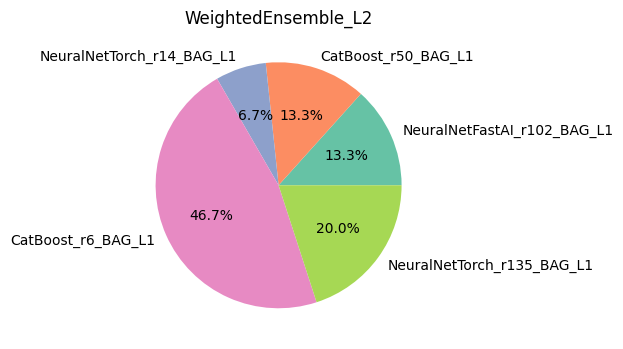

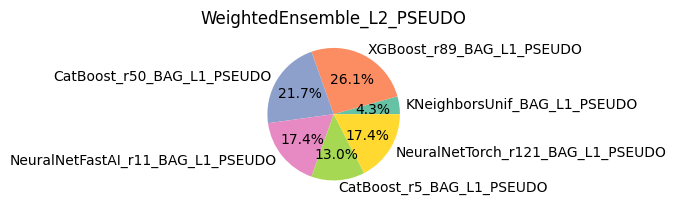

In [9]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [10]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2_PSEUDO,0.905428,roc_auc,0.558263,214.324846,0.000735,0.219391,2,True,222
1,WeightedEnsemble_L2,0.902516,roc_auc,0.596541,168.939661,0.000699,0.201709,2,True,111
2,CatBoost_r5_BAG_L1_PSEUDO,0.901578,roc_auc,0.017308,13.301865,0.017308,13.301865,1,True,182
3,CatBoost_r50_BAG_L1_PSEUDO,0.901150,roc_auc,0.035318,14.078800,0.035318,14.078800,1,True,144
12,CatBoost_r6_BAG_L1,0.899394,roc_auc,0.016278,12.103841,0.016278,12.103841,1,True,85
13,CatBoost_r50_BAG_L1,0.899127,roc_auc,0.022380,12.625915,0.022380,12.625915,1,True,33
15,XGBoost_r89_BAG_L1_PSEUDO,0.898389,roc_auc,0.059757,8.546109,0.059757,8.546109,1,True,140
26,NeuralNetTorch_r121_BAG_L1_PSEUDO,0.897166,roc_auc,0.151974,121.203053,0.151974,121.203053,1,True,203
40,NeuralNetFastAI_r11_BAG_L1_PSEUDO,0.896056,roc_auc,0.259948,50.667490,0.259948,50.667490,1,True,145
45,NeuralNetFastAI_r102_BAG_L1,0.895684,roc_auc,0.327875,71.163872,0.327875,71.163872,1,True,24


# Collecting and saving OOF files

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
overall_scores = {}
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    overall_scores[model] = cv_score
    
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

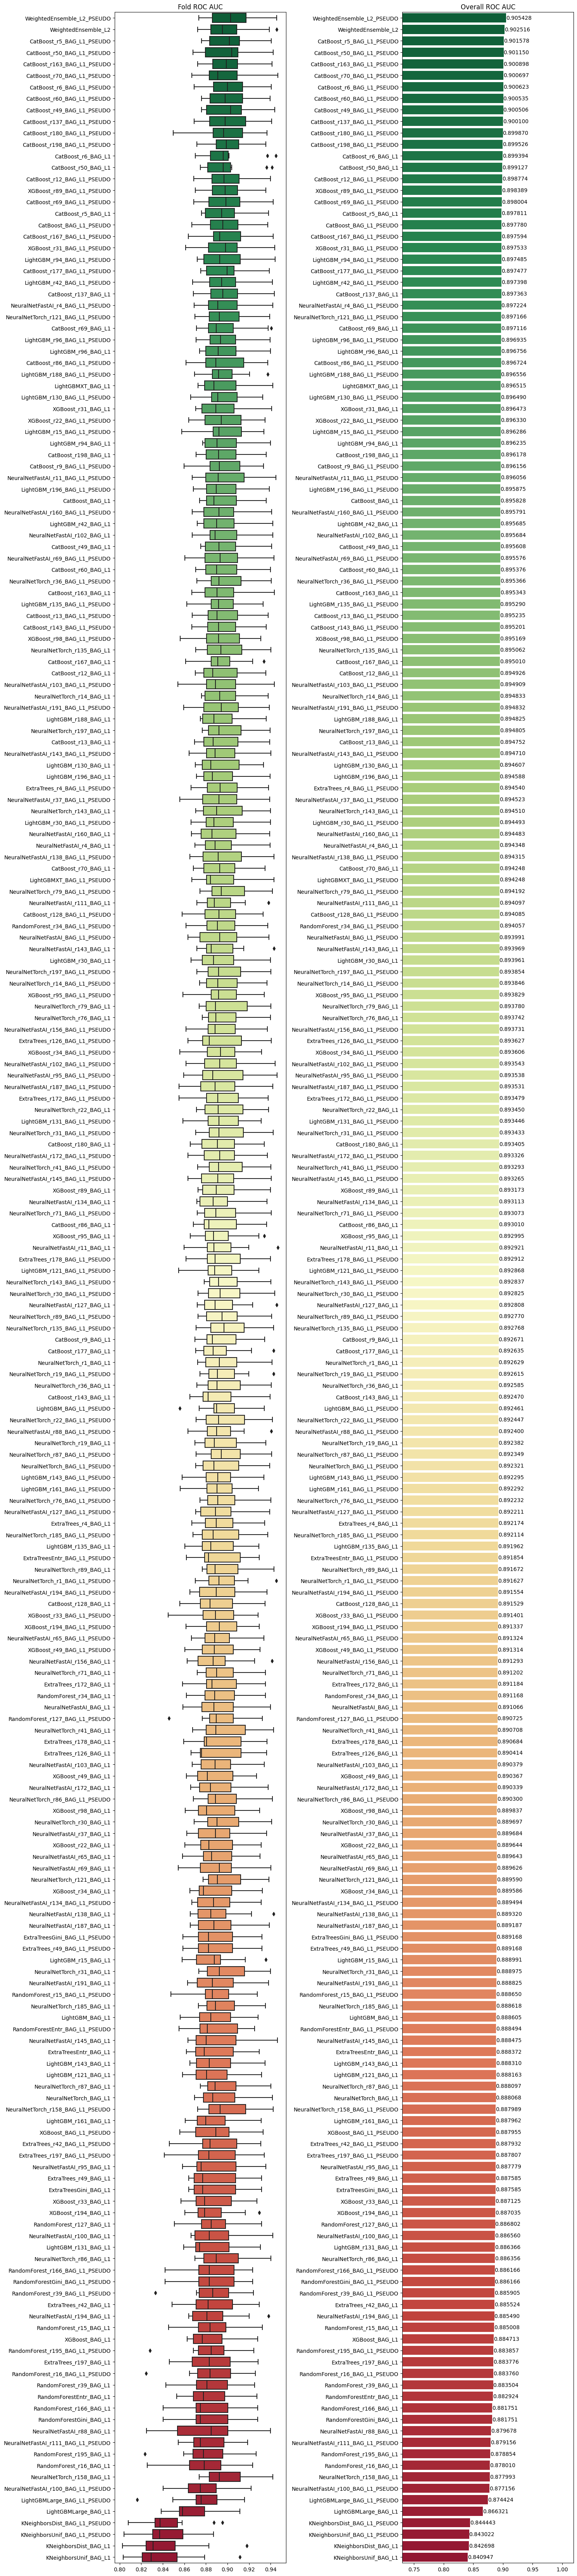

In [15]:
scores_df = pd.DataFrame(scores)
overall_scores_series = pd.Series({k: v for k, v in overall_scores.items()})
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = min(scores_df.min().min(), overall_scores_series.min())
max_score = max(scores_df.max().max(), overall_scores_series.max())
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores) * 0.3))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold ROC AUC")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall ROC AUC")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(overall_scores_series[order]):
    barplot.text(score, i, f"{score:.6f}", va="center")

plt.tight_layout()
plt.show()